## 0. Parameters and Initialization ##

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import loadmat, savemat
from util import mosaic, status_check
import matplotlib.pyplot as plt
from numpy.ma import masked_array
import skimage
from skimage.filters import threshold_otsu
import time
import dcemri
import pydicom as dicom


# SCRIPT FLAGS
plotting = True
reduce_problem = False
Rel = 4.5   # Relaxivity of Gd-DTPA at 3 T [s^-1 [mmol Gd-DTPA]^{-1}]   
flip_angle = 30 * pi / 180.0 # rad
TR = 5e-3   # sec
nx = 80
ny = 50
nt = 61
t = 6.0*arange(nt)  # 6 s per dynamic


data_dir = 'qiba/v9'
#file_ext = 'QIBA_v9_Tofts_S0_500_6s_0s_sigma_5'
file_ext = 'QIBA_v9_Tofts_S0_10000_6s_0s_sigma_100'

In [3]:
# add cubehelix3 color map
mpl.cm.register_cmap(name='cubehelix3', data=mpl._cm.cubehelix(gamma=1.0, s=0.4, r=-0.5, h=1.5))

## 1. Load data ##

In [4]:
data_dicom = zeros((nt, nx, ny))
for k in range(nt):
    file_name = '%s/%s_%03d.dcm' % (data_dir, file_ext, k+1)
    dcm = dicom.read_file(file_name)
    data_dicom[k,:,:] = dcm.pixel_array.astype('float')
    #print k, dcm.pixel_array.shape, file_name
    
data_dce = data_dicom[:,10:70,:]
nt, nx, ny = data_dce.shape
T1map = ones((nx, ny)) # s
#S0map = ones((nx, ny)) * 50000.0 #
data_aif = mean(mean(data_dicom[:,70:,:], axis=2), axis=1)

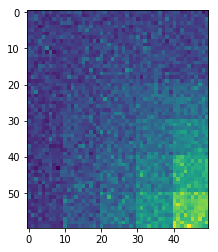

In [5]:
imshow(data_dce[:,:,:].max(axis=0), interpolation='nearest')

Text(0.5,1,'example tissue signal curve')

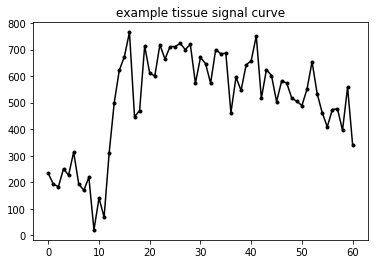

In [6]:
plot(data_dce[:,-1,-1],'k.-')
title('example tissue signal curve')

## 2. Derive the AIF ##

In [7]:
# turn Sb into Cp
T1p = 1.440
R1p = 1.0 / T1p
Hct = 0.45
S0 = data_aif[:10].mean()
R1_eff_aif = dcemri.dce_to_r1eff(data_aif, S0, R1p, TR, flip_angle)
Cb = dcemri.r1eff_to_conc(R1_eff_aif.flatten(), R1p, Rel)  
Cp = Cb.flatten() / (1.0 - Hct)

converting DCE signal to effective R1
converting effective R1 to tracer tissue concentration


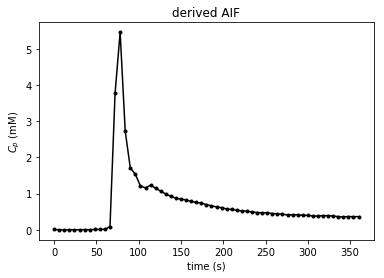

In [8]:
if plotting:
    figure(1)
    clf()
    plot(t, Cp, 'k.-')
    xlabel('time (s)')
    ylabel('$C_p$ (mM)')
    title('derived AIF')
    savefig('qiba/qiba_v9_aif.pdf')

## 3. Reduce the problem size averaging 10x10 ROIs to single pixels. ##

In [9]:
data_dce = transpose(data_dce, (1,2,0)).copy('C')

if reduce_problem:
    nxx = 6
    nyy = 5
    data_dce_red = zeros((nxx, nyy, nt))
    t1_map_red = zeros((nxx, nyy))
    s0_map_red = zeros((nxx, nyy))
    for x in range(nxx):
        for y in range(nyy):
            tmp = data_dce[10*x:10*(x+1), 10*y:10*(y+1), :]
            data_dce_red[x,y,:] = mean(mean(tmp, axis=0), axis=0)
            tmp = T1map[10*x:10*(x+1), 10*y:10*(y+1)]
            t1_map_red[x,y] = mean(tmp)
    data_dce = data_dce_red
    T1map = t1_map_red
    nx = nxx
    ny = nyy

## 4. Convert signal to tissue concentration $C_t$ ##

In [10]:
R1map = 1.0 / T1map

In [11]:
data_dce = reshape(data_dce, (nx, ny, nt))
S0 = data_dce[:,:,:10].mean(axis=2)
R1_eff = dcemri.dce_to_r1eff(data_dce, S0, R1map.T, TR, flip_angle)

converting DCE signal to effective R1


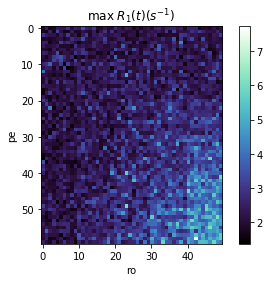

In [12]:
# show map of R1_eff 
R1_eff = reshape(R1_eff, (nx, ny, nt))
if plotting:
    figure(7)
    clf()
    imshow(mosaic(R1_eff.max(axis=2)), interpolation='nearest', cmap='cubehelix3')
    title('max $R_1(t) (s^{-1})$')
    xlabel('ro')
    ylabel('pe')
    colorbar()

In [13]:
# convert effecitve R1 to tissue concentration Ct
Ct = dcemri.r1eff_to_conc(transpose(R1_eff, (2,0,1)), R1map, Rel)
Ct = transpose(Ct, (1,2,0))

converting effective R1 to tracer tissue concentration


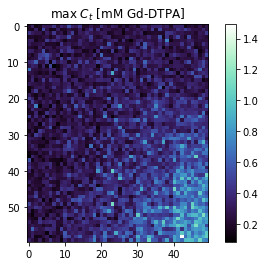

In [14]:
# show map of Ct
Ct = reshape(Ct, (nx, ny, nt))
if plotting:
    figure(9)
    clf()
    imshow(Ct.max(axis=2), interpolation='nearest', cmap='cubehelix3')
    title('max $C_t$ [mM Gd-DTPA]')
    colorbar()
    savefig('qiba/qiba_v9_Ct.pdf')
Ct = reshape(Ct, (-1, nt))

## 5. Fit voxel-wise Ct to the model to get $K^{trans}$ and $v_e$. ##

In [ ]:
import imp
dcemri = imp.reload(dcemri)
params, covs =  dcemri.fit_tofts_model(Ct, Cp, t, extended=False)

fitting perfusion parameters
using Standard Tofts-Kety
fitting 3000 voxels


/home/jpeterson/Programming/3P/pydcemri/dcemri.py:125: RuntimeWarning: overflow encountered in exp
  tmp = cumtrapz(exp(-(Kt/ve)*(t[k] - t[:k+1]))*Cp[:k+1],
/home/jpeterson/Programming/sbs/sbsvenv/lib/python3.5/site-packages/scipy/integrate/quadrature.py:287: RuntimeWarning: invalid value encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)
/home/jpeterson/Programming/sbs/sbsvenv/lib/python3.5/site-packages/scipy/integrate/quadrature.py:287: RuntimeWarning: overflow encountered in multiply
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)
/home/jpeterson/Programming/3P/pydcemri/dcemri.py:125: RuntimeWarning: overflow encountered in multiply
  tmp = cumtrapz(exp(-(Kt/ve)*(t[k] - t[:k+1]))*Cp[:k+1],
/home/jpeterson/Programming/sbs/sbsvenv/lib/python3.5/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


10% complete, 633 of 703 s remain
20% complete, 549 of 686 s remain
30% complete, 455 of 650 s remain
40% complete, 372 of 621 s remain
50% complete, 301 of 603 s remain
60% complete, 228 of 571 s remain
70% complete, 163 of 546 s remain


In [ ]:
Kt = zeros(nx*ny)
idxs_dce = range(nx*ny)
Kt[idxs_dce] = params[0]
ve = zeros(nx*ny)
ve[idxs_dce] = params[1]
Kt = reshape(Kt, (nx, ny))
ve = reshape(ve, (nx, ny))

In [ ]:
# convert Kt to min$^{-1}$
Kt = Kt * 60.0

In [ ]:
# PLOT RESULTS
if plotting:
    figure(13)
    clf()
    imshow(Kt, interpolation='nearest', cmap='cubehelix3', vmin=0, vmax=0.5)
    #plot(Kt.T,'o-')
    colorbar()
    title('$K^{trans}$ (min$^{-1}$)')
    savefig('qiba/qiba_v9_Kt.pdf')

    figure(14)
    clf()
    imshow(ve, interpolation='nearest', cmap='cubehelix3', vmin=0, vmax=1)
    #plot(ve,'o-')
    title('$v_e$')
    colorbar()
    savefig('qiba/qiba_v9_ve.pdf')

In [ ]:
if reduce_problem:
    u = ones(1)
else:
    u = ones(10)
Kt_truth = hstack([0.01*u, 0.02*u, 0.05*u, 0.1*u, 0.2*u, 0.35*u])
ve_truth = hstack([0.01*u, 0.05*u, 0.1*u, 0.2*u, 0.5*u])
Kt_error = ((Kt.T - Kt_truth) / Kt.T).T
ve_error = (ve - ve_truth) / ve

In [ ]:
if plotting:
    figure(10)
    imshow(Kt_error, interpolation='nearest', cmap='bwr', vmin=-2, vmax=2)
    title('relative error in $K^{trans}$')
    colorbar()
    savefig('qiba/qiba_v9_error_Kt.pdf')

    
    figure(11)
    imshow(ve_error, interpolation='nearest', cmap='bwr', vmin=-2, vmax=2)
    title('relative error in $v_e$')
    colorbar()
    savefig('qiba/qiba_v9_error_ve.pdf')

In [ ]:
# mean relative error
print('rms relative error in Kt:', abs(Kt_error).mean())
print('rms relative error in ve:', abs(ve_error).mean())

In [ ]:
h = hist(Kt_error, 100)